In [99]:
from statistics import median
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
# Leer los datos del archivo JSON
data_raw = pd.read_json('./Ventas_registro.json')

In [72]:
# Desanidamos los productos para usar los valores anidados (nombre - cantidad - total)
data_flat = pd.json_normalize(data_raw.to_dict(orient='records'), record_path='productos', meta=['tipo_venta', 'fecha_venta', 'pago_total', 'cliente'])

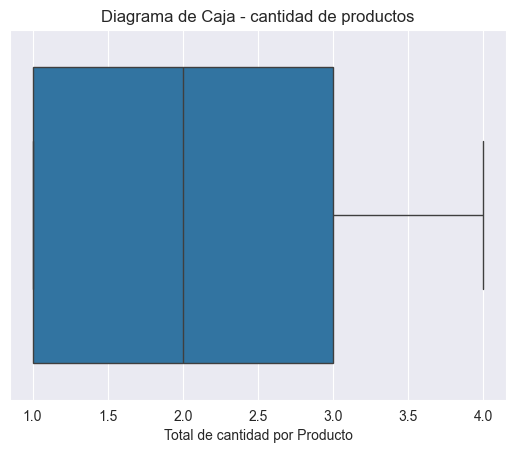

In [22]:
## DEFINICIÓN DE VARIABLESE CANTIDAD, TOTAL, PAGO_TOTAL
sns.boxplot(data=data_flat, x='cantidad', legend='auto')
plt.title('Diagrama de Caja - cantidad de productos')
plt.xlabel('Total de cantidad por Producto')
plt.show()

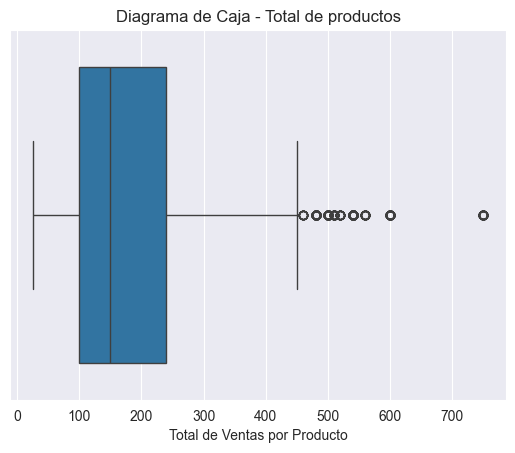

In [12]:
sns.boxplot(data=data_flat, x='total', legend='auto')
plt.title('Diagrama de Caja - Total de productos')
plt.xlabel('Total de Ventas por Producto')
plt.show()

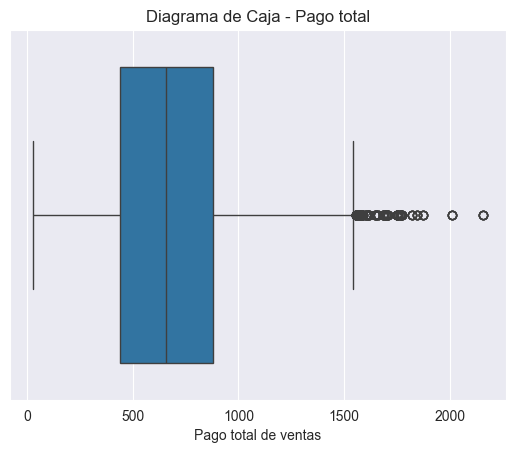

In [16]:
sns.boxplot(data=data_flat, x='pago_total', legend='auto')
plt.title('Diagrama de Caja - Pago total')
plt.xlabel('Pago total de ventas')
plt.show()

In [105]:
from scipy.stats import zscore
import numpy as np

data_outliers = data_flat[['cantidad', 'total', 'pago_total']].astype(float)
z_scores = np.abs(zscore(data_outliers))
outliers = (z_scores > 3)
data_only_outliers = data_flat[outliers.any(axis=1)]

print("Registros considerados outliers:")
print(data_only_outliers)
print(f"Cantidad de registros considerados como outliers: {data_only_outliers.shape[0]}")


Registros considerados outliers:
                                           nombre  cantidad  total tipo_venta  \
87                            Chaqueta alcolchada         3  600.0          1   
244                           Chaqueta alcolchada         3  600.0          0   
406                           Chaqueta alcolchada         3  600.0          0   
738                           Chaqueta alcolchada         3  600.0          0   
1087                          Chaqueta alcolchada         3  600.0          0   
...                                           ...       ...    ...        ...   
29242  Vestido estilo boho con detalles de flecos         4  560.0          1   
29286         Vestido de saten con tirantes finos         4  520.0          1   
29313  Vestido estilo boho con detalles de flecos         4  560.0          1   
29319      Sueter oversized con detalles de rayas         4  540.0          0   
29342      Sueter oversized con detalles de rayas         4  540.0          

In [25]:
data_flat.shape

(29348, 7)

In [119]:
# Asegúrate de limpiar y verificar los datos
data_cleaned = data_flat[['cantidad', 'total', 'pago_total']].apply(pd.to_numeric, errors='coerce').dropna()

if not data_cleaned.empty:
    # Calcular distancias de Mahalanobis
    data_cleaned['Distancia_mahalanobis'] = mahalanobis(x=data_cleaned, data=data_cleaned)

    # Identificar y mostrar outliers
    outliers = data_cleaned[data_cleaned['Distancia_mahalanobis'] > 3]
    print("Registros considerados outliers:")
    print(outliers)
    print(f"Cantidad de registros considerados como outliers: {outliers.shape[0]}")
else:
    print("No hay datos válidos para calcular las distancias.")


Registros considerados outliers:
       cantidad  total  pago_total  Distancia_mahalanobis
0             3  390.0         990          208197.788526
1             1   80.0         990          208619.965088
2             2  160.0         990          207793.020894
3             3  360.0         990          207951.378699
4             2   90.0         615          207219.455435
...         ...    ...         ...                    ...
29343         4  300.0         840          205983.761375
29344         1   65.0          65          208496.049158
29345         3  360.0         530          207951.431477
29346         1   90.0         530          208698.691577
29347         1   80.0         530          208616.891656

[29348 rows x 4 columns]
Cantidad de registros considerados como outliers: 29348


In [121]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las variables a escalar
scaler = StandardScaler()

# Escalar las variables cuantitativas
scaled_features = scaler.fit_transform(data_flat[['cantidad', 'total', 'pago_total']])

# Crear un nuevo DataFrame con las características escaladas
data_scaled = pd.DataFrame(scaled_features, index=data_flat.index, columns=['cantidad', 'total', 'pago_total'])

# Añadir las variables escaladas al DataFrame original
data_flat[['cantidad_escalada', 'total_escalada', 'pago_total_escalada']] = data_scaled

# Ver los primeros registros escalados
print(data_flat[['cantidad', 'total', 'pago_total', 'cantidad_escalada', 'total_escalada', 'pago_total_escalada']].head())


   cantidad  total pago_total  cantidad_escalada  total_escalada  \
0         3  390.0        990           1.092372        1.911814   
1         1   80.0        990          -1.227461       -0.939555   
2         2  160.0        990          -0.067545       -0.203718   
3         3  360.0        990           1.092372        1.635875   
4         2   90.0        615          -0.067545       -0.847576   

   pago_total_escalada  
0             1.034946  
1             1.034946  
2             1.034946  
3             1.034946  
4            -0.166287  


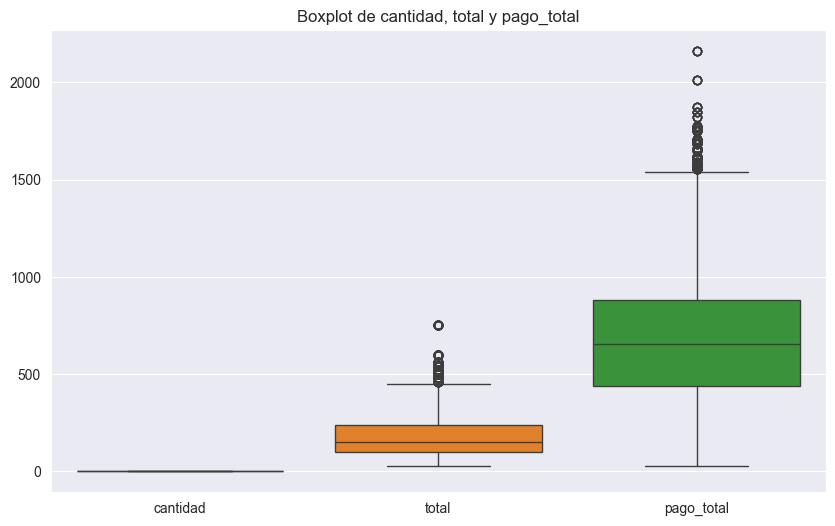

In [62]:
# Graficar boxplot de las variables cuantitativas para ver los outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_flat[['cantidad', 'total', 'pago_total']])
plt.title('Boxplot de cantidad, total y pago_total')
plt.show()


In [122]:
#VALORES MISSING
#DIVISION DE LOS DATOS EN CUALITATIVOS Y CUANTITATIVOS
data_cuali = data_flat.drop(["cantidad", "total", "pago_total"], axis=1)
data_cuanti = data_flat.drop(["nombre", "tipo_venta", "fecha_venta", "cliente"], axis=1)

prom_cantidad = data_cuanti["cantidad"].astype("float").mean(axis=0)
print("Cantidad promedio es: ", prom_cantidad)
prom_total = data_cuanti["total"].astype("float").mean(axis=0)
print("Total promedio es: ", prom_total)
prom_pago_total = data_cuanti["pago_total"].astype("float").mean(axis=0)
print("Pago total promedio es: ", prom_pago_total)

# IMPUTACION FORMA III - UTILIZANDO LA MEDIANA
data_cuanti["cantidad"] = data_cuanti["cantidad"].fillna(data_cuanti.cantidad.median())
data_cuanti["total"] = data_cuanti["total"].fillna(data_cuanti.total.median())
data_cuanti["pago_total"] = data_cuanti["pago_total"].fillna(data_cuanti.pago_total.median())
data_cuanti.describe()

Cantidad promedio es:  2.058232247512607
Total promedio es:  182.14815319612921
Pago total promedio es:  666.9114420062696


C:\Users\CLAPTON\AppData\Local\Temp\ipykernel_16632\4173648307.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cuanti["pago_total"] = data_cuanti["pago_total"].fillna(data_cuanti.pago_total.median())


,cantidad,total,pago_total,cantidad_escalada,total_escalada,pago_total_escalada
count,29348.000000,29348.000000,29348.000000,2.934800e+04,2.934800e+04,2.934800e+04
mean,2.058232,182.148153,666.911442,1.936875e-16,-5.423251e-17,8.522252e-17
std,0.862146,108.721534,312.184376,1.000017e+00,1.000017e+00,1.000017e+00
min,1.000000,25.000000,25.000000,-1.227461e+00,-1.445443e+00,-2.056228e+00
25%,1.000000,100.000000,440.000000,-1.227461e+00,-7.555960e-01,-7.268631e-01
50%,2.000000,150.000000,655.000000,-6.754455e-02,-2.956976e-01,-3.815580e-02
75%,3.000000,240.000000,880.000000,1.092372e+00,5.321194e-01,6.825844e-01
max,4.000000,750.000000,2160.000000,2.252289e+00,5.223082e+00,4.782795e+00


In [88]:
# EVALUAMOS ASIMETRIA Y KURTOSIS DE LAS VARIABLES
from scipy.stats import kurtosis
from scipy.stats import skew

for variable in ["cantidad", "total", "pago_total"]:
    print("\n", data_cuanti[variable].name, ":")
    print("Asimetria:", skew(data_cuanti[variable].dropna()))
    print("Kurtosis:", kurtosis(data_cuanti[variable].dropna()))


 cantidad :
Asimetria: 0.11445559292844287
Kurtosis: -1.1812787117531496

 total :
Asimetria: 1.1076876093412975
Kurtosis: 1.3793226432917445

 pago_total :
Asimetria: 0.34417637762491754
Kurtosis: 0.002208080851722194


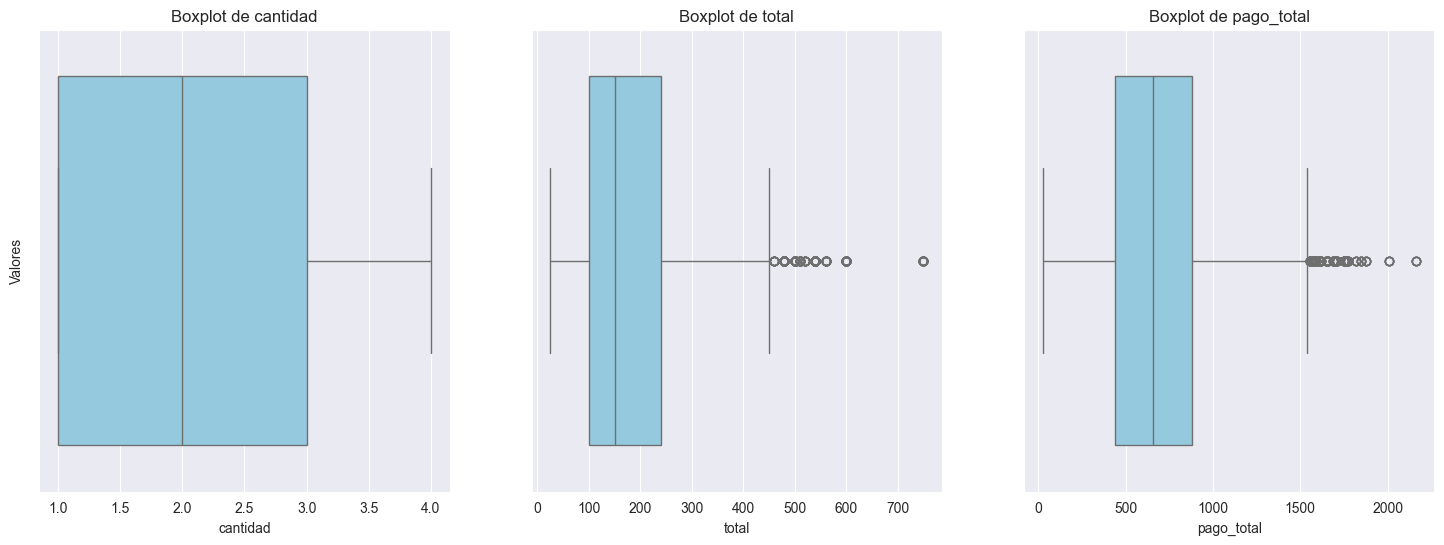

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

varibles = ["cantidad", "total", "pago_total"]

for i, varible in enumerate(varibles):
    sns.boxplot(data=data_cuanti, x = varible, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot de {varible}")
    axes[i].set_xlabel(f"{varible}")
    axes[i].set_ylabel("Valores")

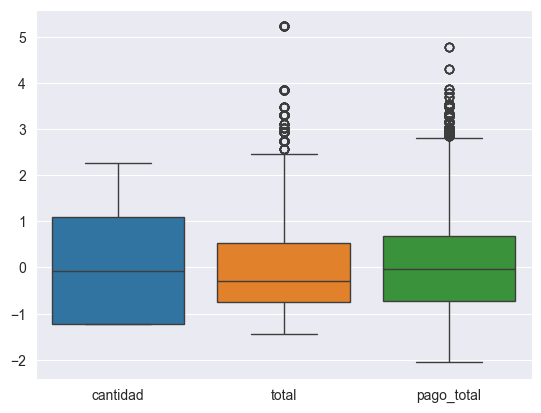

In [63]:
#BOXPLOTS CON VARIABLES ESTANDARIZADAS
sns.boxplot(data=data_scaled);

In [91]:
#VALORES OUTLIERS BASANDDOSE EN Z-SCORE
data_scaled["cantidad"]<3

0        True
1        True
2        True
3        True
4        True
         ... 
29343    True
29344    True
29345    True
29346    True
29347    True
Name: cantidad, Length: 29348, dtype: bool

In [133]:
#INTERVALO DE CUATILES
Q1 = data_flat[['cantidad', 'total', 'pago_total']].quantile(0.25)
Q3 = data_flat[['cantidad', 'total', 'pago_total']].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1 * IQR
limite_superior = Q3 + 1 * IQR

# Filtrar los datos que son outliers
outliers = (data_flat[['cantidad', 'total', 'pago_total']] < limite_inferior) | (data_flat[['cantidad', 'total', 'pago_total']] > limite_superior)

# Mostrar los registros que son outliers
outliers_data = data_flat[outliers.any(axis=1)]
print("Registros considerados outliers:")
print(outliers_data)
print(f"Cantidad de registros considerados como outliers: {outliers_data.shape[0]}")


Registros considerados outliers:
                                              nombre  cantidad  total  \
0                                   Pantalones capri         3  390.0   
16                         Chaqueta de cuerina negro         3  405.0   
21                          Chaqueta acolchada negra         3  435.0   
33                              Sueter de punto fino         3  420.0   
35                               Chaqueta alcolchada         2  400.0   
...                                              ...       ...    ...   
29320             Top con lazo en la parte delantera         1   55.0   
29321       Pantalon de cuero sintetico con cinturon         4  400.0   
29322                    Falda de terciopelo burdeos         2  200.0   
29341  Chaqueta estilo varsity con botones metalicos         4  500.0   
29342         Sueter oversized con detalles de rayas         4  540.0   

      tipo_venta fecha_venta pago_total              cliente  \
0              0  11/03/20